# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using Near-IR region data only



In [ ]:
# Install keras
# !pip install keras==2.1.6

In [ ]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [ ]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


# Data visualization and pre-processing

## Handling missing values

In [ ]:
# Shape of the dataframe
df.shape

(248756, 4)

In [ ]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

In [ ]:
# Replacing all missing values of K with zero
df['k'].fillna(0, inplace = True)

In [ ]:
# Confirming we have handled NUll k values
df.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

## One hot encoding targets (Classes of organic compounds) with integers

In [ ]:
# Get unique values of classes, sort them to ensure always the same order

# encode class values as integers
encoder = LabelEncoder()
df['book'] = encoder.fit_transform(df['book'])

# This is our dictionary for decoding the labels 
# (Same order as indices of probabilities from NN prediction)
classes_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_,))
classes_dictionary = str(classes_dictionary) 

# Write our dictionary to a json file
import json
	
# Write to current runtime
with open("classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

# Write to google drive
with open("/content/drive/MyDrive/colab_data/DLOrganicClassifierData/classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [ ]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,54,6.07550,1.405200,0.000051
1,8,0.63500,1.450667,0.000000
2,29,3.16159,1.389220,0.001243
3,41,1.56441,1.521180,0.000018
4,47,15.68950,1.448270,0.002267


In [ ]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
139953,18,5.65773,1.33081,0.000364,Far_IR
140061,41,1.72167,1.52099,0.000028,IR
195212,45,8.91329,1.46714,0.000870,Far_IR


Let’s see how many of each class is in our data set

In [ ]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

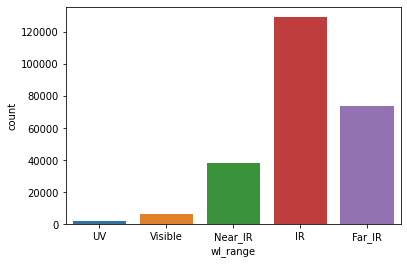

In [ ]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [ ]:
# Lets select only rows within Near_IR
df = df.loc[df['wl_range'].isin(['Near_IR'])]
df.head()

,book,wl,n,k,wl_range
9,6,1.02500,1.405376,0.000000,Near_IR
18,45,1.46613,1.474510,0.000011,Near_IR
26,46,1.41126,1.385010,0.000017,Near_IR
30,42,1.29836,1.477800,0.000029,Near_IR
31,14,1.42562,1.553720,0.000055,Near_IR


In [ ]:
# Describe new df with only Near-Infrared data
df.describe()

,book,wl,n,k
count,37853.000000,37853.000000,37853.000000,37853.000000
mean,34.650754,1.342005,1.440864,0.000035
std,13.637991,0.148999,0.079116,0.000145
min,0.000000,0.750160,1.268000,0.000000
25%,22.000000,1.313400,1.362200,0.000004
50%,40.000000,1.370400,1.436384,0.000020
75%,46.000000,1.432310,1.516220,0.000033
max,59.000000,1.500000,1.651547,0.001940


In [ ]:
df.shape

(37853, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [ ]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (37853, 3)
Targets (y):  (37853,)


## Normalizing Data


In [ ]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
1034,0.728296,-1.627400,0.298695
240124,-0.158357,1.427088,0.097594
244117,-0.225338,-0.704835,-0.232441
233512,0.753665,-0.706478,-0.187410
193126,-0.398158,1.019587,-0.104034
13881,-2.604085,-0.443334,-0.241076
74580,0.171713,1.347205,-0.222444
183719,0.919908,-0.158425,0.077327
33718,0.803196,-1.176292,0.219211
84972,-0.115941,1.427088,0.100351


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [ ]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [ ]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (30282, 3)
y - Train shape:  (30282,)
X - Test shape:  (7571, 3)
y - Test shape:  (7571,)


In [ ]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 60 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

60


In [ ]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 300

In [ ]:
# Model Summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                200       
                                                                 
 dense_16 (Dense)            (None, 100)               5100      
                                                                 
 dense_17 (Dense)            (None, 60)                6060      
                                                                 
Total params: 11,360
Trainable params: 11,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/300
663/663 - 2s - loss: 1.5624 - accuracy: 0.5807 - val_loss: 0.7822 - val_accuracy: 0.8477 - 2s/epoch - 4ms/step
Epoch 2/300
663/663 - 2s - loss: 0.5477 - accuracy: 0.8953 - val_loss: 0.4230 - val_accuracy: 0.9167 - 2s/epoch - 3ms/step
Epoch 3/300
663/663 - 1s - loss: 0.3538 - accuracy: 0.9192 - val_loss: 0.3147 - val_accuracy: 0.9252 - 1s/epoch - 2ms/step
Epoch 4/300
663/663 - 1s - loss: 0.2853 - accuracy: 0.9270 - val_loss: 0.2657 - val_accuracy: 0.9260 - 1s/epoch - 2ms/step
Epoch 5/300
663/663 - 2s - loss: 0.2446 - accuracy: 0.9357 - val_loss: 0.2240 - val_accuracy: 0.9380 - 2s/epoch - 3ms/step
Epoch 6/300
663/663 - 2s - loss: 0.2196 - accuracy: 0.9389 - val_loss: 0.2117 - val_accuracy: 0.9406 - 2s/epoch - 3ms/step
Epoch 7/300
663/663 - 2s - loss: 0.1969 - accuracy: 0.9419 - val_loss: 0.1841 - val_accuracy: 0.9483 - 2s/epoch - 3ms/step
Epoch 8/300
663/663 - 1s - loss: 0.1805 - accuracy: 0.9468 - val_loss: 0.1750 - val_accuracy: 0.9471 - 1s/epoch - 2ms/step
Epoch 9/300
663/

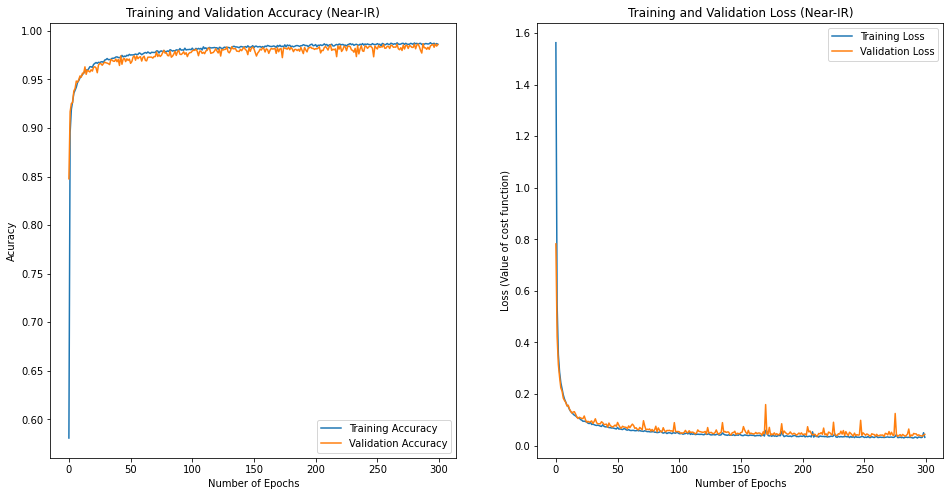

In [ ]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Near-IR)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Near-IR)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [ ]:
# # Save model as h5 (keras model)
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Near_IR_organic_model.h5')

In [ ]:
# # Save the entire model as a SavedModel in drive
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Near_IR_organic_model') 

# Model Evaluation

In [ ]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.9844142198562622
The test Loss is:  0.042885664850473404


In [ ]:
# Classification report
y_pred = model.predict(x_test) # Whole test set
classes = encoder.classes_.tolist() # Convert our array of labels (classes) to list

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names = classes, labels = range (60) ))

                                                  precision    recall  f1-score   support

    (C10H8O4)n (Polyethylene terephthalate, PET)       1.00      0.89      0.94        19
                 (C16H14O3)n (Polycarbonate, PC)       0.94      0.68      0.79        25
  (C2ClF3)n (Polychlorotrifluoroethylene, PCTFE)       0.00      0.00      0.00         0
             (C2H3Cl)n (Polyvinyl chloride, PVC)       0.79      0.94      0.86        16
          (C2H4)n (Polyethylene, PE, HDPE, LDPE)       0.00      0.00      0.00         0
               (C2H4O)n (Polyvinyl alcohol, PVA)       1.00      1.00      1.00        18
         (C2H6OSi)n (Polydimethylsiloxane, PDMS)       0.96      0.98      0.97       188
             (C37H24O6N2)n (Polyetherimide, PEI)       1.00      1.00      1.00        10
                (C3H4O2)n (Polylactic acid, PLA)       0.00      0.00      0.00         0
     (C5H8O2)n (Poly(methyl methacrylate), PMMA)       0.67      0.72      0.69        67
         

***Some conclusions & disccusion***

---



**Despite Near IR data being too small compared to Middle Ir & Far Ir, it's model still produces better accuracy than all regions in the IR spectrum. This possibly implies that, the Near IR region is better suited for optical classification of organic compounds based on optical dispersive methods with a single wavelength of light.**

**On comparison to the UV & Visible region of the electromagnetic spectrum, Near - IR is roughly the same as them with slight differences. Near-IR seems to slightly perform better than UV and even better that Visible. These differences may be a result of data augmentation performed on UV & Visible data as an attempt to increase data for training the artificial neural networks, so the UV & Visible data are not a good representative of real data compared to the original Near IR. With additional experimental data and hyper-parameter optimizations, the differences in this region might be almost negligible.** **More on this can be observed from their training and validation loss and accuracy plots. The plots obtained from Near-IR model are more smoother and the lines converge well, while plots for models containing augmented data show convergence but with bumpy validation lines. This implies that the validation dataset is not a good representation of the training data set, which maybe true due to artificially synthesized data from data augmentation process which introduced noice, and by by using zero for all values of K in the augmented data. Overrall, the models in this regions seems to perform well because both the validation and training lines converge well with higher accuracies compared to Far-Ir and Middle -IR regions.**

**From the results,roughly, it seems that the deep lerning models for optical classification of organic compounds performs better from Near -IR, UV and visible regions (regions of low wavelengths) and the accuracy decreases towards the Far-IR region (high wavelengths region). So we reccomend the use of deep learning models from the Near -IR, UV and visible regions for accurate classification of organic compounds based on optical dispersive methods with a single wavelength of light.**